# Electricity Demand Forecast - Pre-Assessment2

In [1]:
# Reverse Predict by predicting Energy Generation for next 6 months
# Use OLS to predict annual buffer between generation and consumption
# Calculate consumption forecast by removing buffer, taking buffer as mean buffer for every month
# Check accuracy by taking OLS annual forecast of subsectors and add them up

In [2]:
import numpy as np
import pandas as pd

# Explore Data

In [3]:
raw_data = pd.read_csv("./raw_dataset/Electricity Generation Tidy - tablebuilder.singstat.gov.sgtableTSM890831.csv")
raw_data.tail()

,Data Series,Electricity Generation
572,1975 May,351
573,1975 Apr,349
574,1975 Mar,343
575,1975 Feb,290
576,1975 Jan,342


In [4]:
raw_data['Data Series'] = pd.to_datetime(raw_data['Data Series'])

In [5]:
raw_data.sort_values(by=['Data Series'], inplace=True)
raw_data.reset_index(drop=True, inplace=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data Series             577 non-null    datetime64[ns]
 1   Electricity Generation  577 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 9.1 KB


<AxesSubplot: xlabel='Data Series'>

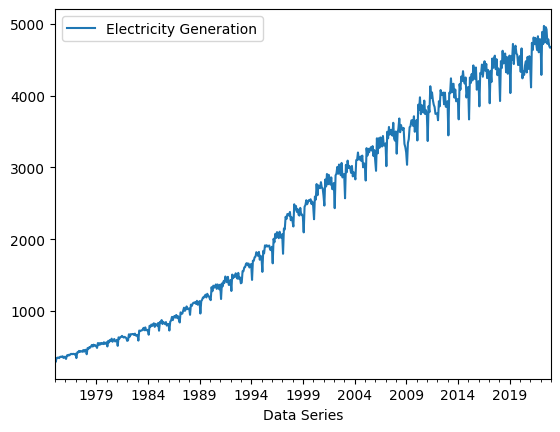

In [6]:
# Plot overall chart
raw_data.plot.line(x='Data Series', y='Electricity Generation')

# Make data stationary

In [7]:
data_to_transform = raw_data

<AxesSubplot: xlabel='Data Series'>

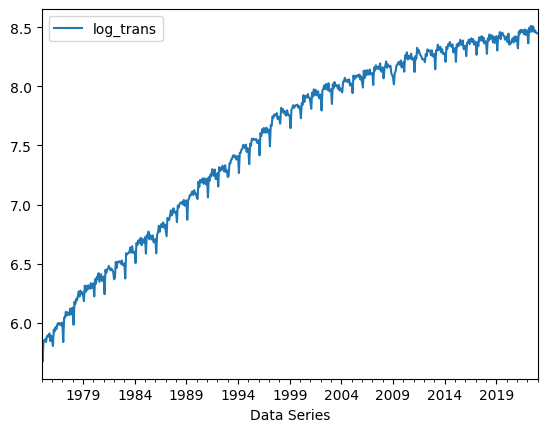

In [31]:
#log transform
data_to_transform['log_trans'] = np.log(data_to_transform['Electricity Generation'])
data_to_transform.plot.line(x='Data Series', y='log_trans')

<AxesSubplot: xlabel='Data Series'>

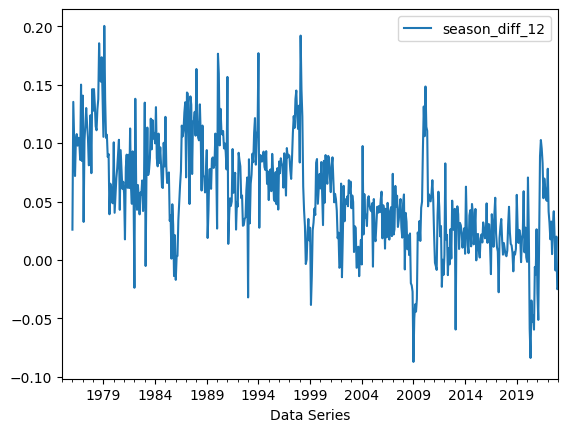

In [32]:
data_to_transform['season_diff_12'] = data_to_transform['log_trans'].diff(periods=12)
data_to_transform.plot.line(x='Data Series', y='season_diff_12')

<AxesSubplot: xlabel='Data Series'>

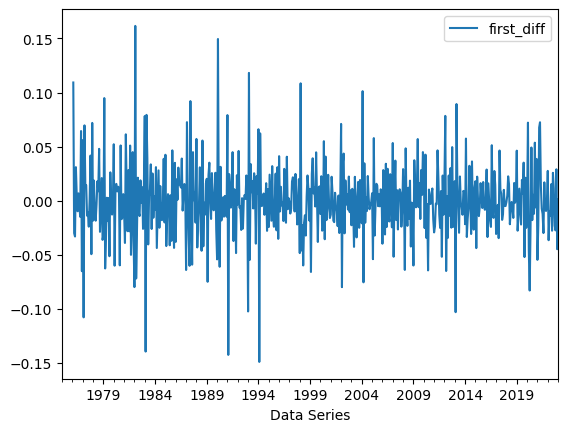

In [33]:
data_to_transform['first_diff'] = data_to_transform['season_diff_12'].diff()
data_to_transform.plot.line(x='Data Series', y='first_diff')

# ACF and PACF plots

C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


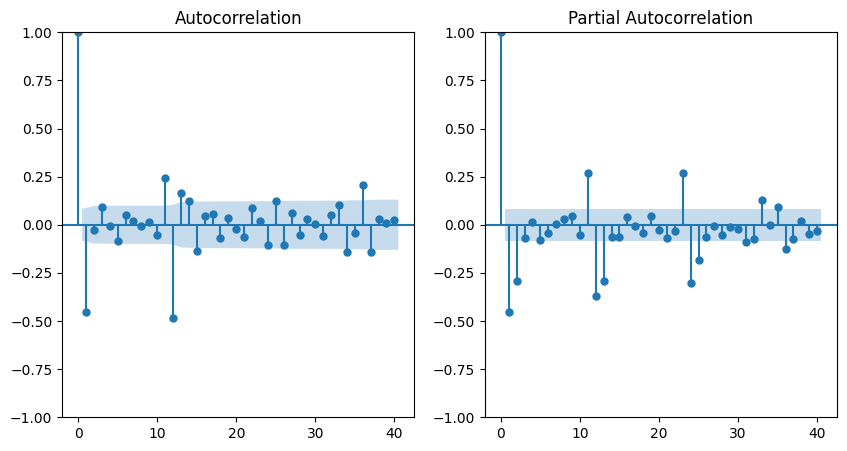

In [34]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

dta = data_to_transform['first_diff']
dta.index = data_to_transform['Data Series']


fig, ax = plt.subplots(1,2,figsize=(10,5))
sm.graphics.tsa.plot_acf(dta.dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(dta.dropna(), lags=40, ax=ax[1])
plt.show()

In [35]:
# AR = 2 (See pacf plot)
# MA = 1 (See acf plot)
# SAR = 3
# SMA = 2
# m_season = 12

# SARIMA Model

In [36]:
num_of_prediction = 12 

In [37]:
data_sarima= data_to_transform[['Data Series', 'log_trans']]
data_sarima.tail()

,Data Series,log_trans
572,2022-09-01,8.459564
573,2022-10-01,8.472614
574,2022-11-01,8.454253
575,2022-12-01,8.448057
576,2023-01-01,8.448486


In [38]:
sarima_model = sm.tsa.statespace.SARIMAX(data_sarima['log_trans'], order=(2, 1, 1), seasonal_order=(3,1,2,12)).fit()

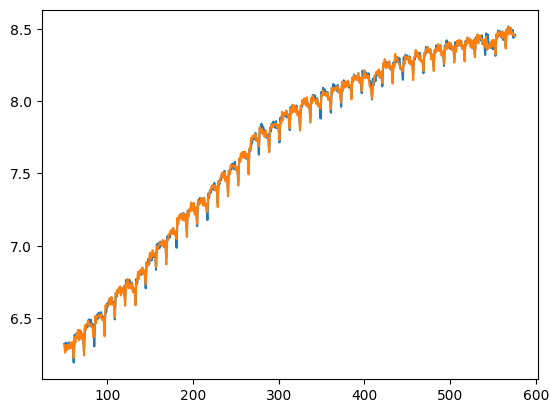

In [39]:
import matplotlib.pyplot as plt

#Fitted values plot
plt.plot(sarima_model.fittedvalues[50:])
plt.plot(data_sarima['log_trans'][50:])

Text(0.5, 0, 'integrated data')

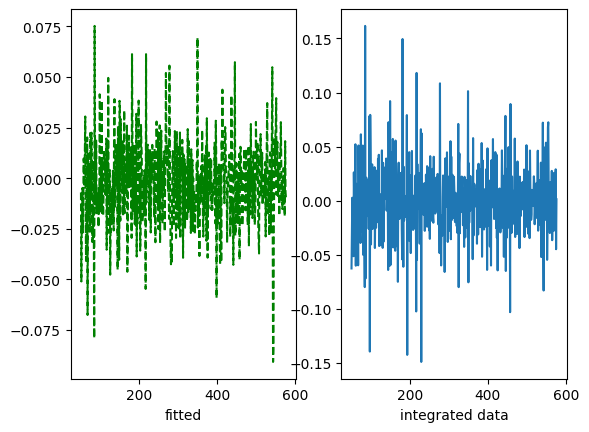

In [40]:
import matplotlib.pyplot as plt

#Fitted values plot
plt.subplot(121)
plt.plot(sarima_model.resid[50:], "g--")
plt.xlabel("fitted")
plt.subplot(122)
plt.plot(data_to_transform['first_diff'][50:])
plt.xlabel("integrated data")

# Check fitted ACF and PACF residuals plots

C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


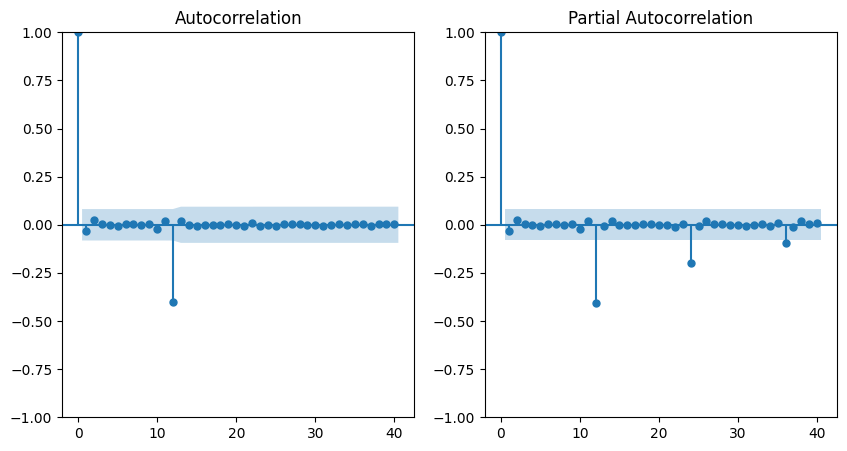

In [41]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

dta = sarima_model.resid
dta.index = data_to_transform['Data Series']


fig, ax = plt.subplots(1,2,figsize=(10,5))
sm.graphics.tsa.plot_acf(dta.dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(dta.dropna(), lags=40, ax=ax[1])
plt.show()

# Prediction

In [42]:
pred_count = 12

In [99]:
forecast_dates = pd.date_range(
        start=data_sarima['Data Series'].max()+ pd.DateOffset(months=1),
        periods=pred_count,  # An extra in case we include start
        freq='MS')

In [133]:
forecast = sarima_model.get_prediction(start=len(data_sarima), end=len(data_sarima)+pred_count-1, dynamic=False)

In [134]:
forecast_df = pd.concat([pd.DataFrame(forecast_dates), pd.DataFrame(forecast.predicted_mean).reset_index(drop=True)], axis=1).set_axis(['Data Series', 'log_trans'], axis=1)
forecast_df = forecast_df[forecast_df['Data Series']>data_sarima['Data Series'].max()]

In [135]:
forecast_df

,Data Series,log_trans
0,2023-02-01,8.374386
1,2023-03-01,8.487110
2,2023-04-01,8.451256
3,2023-05-01,8.494538
4,2023-06-01,8.465841
5,2023-07-01,8.495433
6,2023-08-01,8.496397
7,2023-09-01,8.464286
8,2023-10-01,8.498271
9,2023-11-01,8.451547


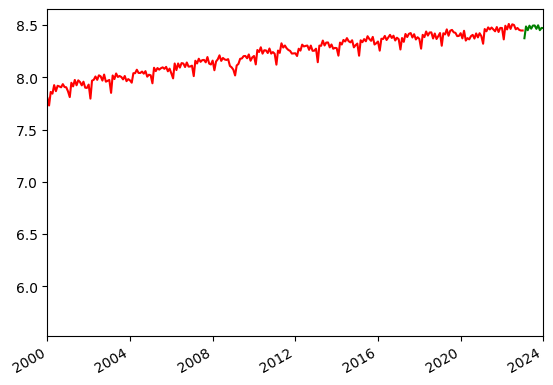

In [136]:
import datetime
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.set_xlim([datetime.date(2000, 1, 1), datetime.date(2024, 1, 1)])

plt.plot(data_sarima['Data Series'], data_sarima['log_trans'], "r")
plt.plot(forecast_df['Data Series'], forecast_df['log_trans'], "g")

# Electricity Generation - Inverse transform

In [137]:
forecast_df['Predicted Generation'] = np.exp(forecast_df['log_trans'])
forecast_df

,Data Series,log_trans,Predicted Generation
0,2023-02-01,8.374386,4334.605733
1,2023-03-01,8.487110,4851.824154
2,2023-04-01,8.451256,4680.948433
3,2023-05-01,8.494538,4887.998095
4,2023-06-01,8.465841,4749.718880
5,2023-07-01,8.495433,4892.376682
6,2023-08-01,8.496397,4897.093296
7,2023-09-01,8.464286,4742.341904
8,2023-10-01,8.498271,4906.276735
9,2023-11-01,8.451547,4682.311936
